In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2025-06-05 05:58:53.984173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749103134.261793      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749103134.343332      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# CONFIG
BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS = 10
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
# Load labels
df = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
df['id_code'] = df['id_code'].apply(lambda x: x + ".png")
df['diagnosis'] = df['diagnosis'].astype(str)


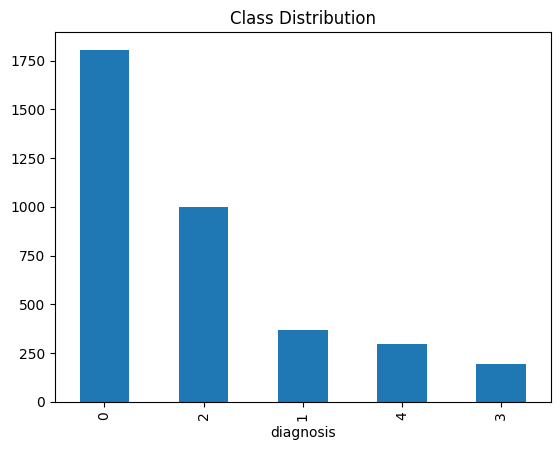

In [4]:
# Visualize Class Distribution
df['diagnosis'].value_counts().plot(kind='bar', title='Class Distribution');

In [5]:
#Prepare paths
image_dir = '/kaggle/input/aptos2019-blindness-detection/train_images/'
df['filepath'] = df['id_code'].apply(lambda x: os.path.join(image_dir, x))

In [8]:
df['filepath'][0]

'/kaggle/input/aptos2019-blindness-detection/train_images/000c1434d8d7.png'

In [9]:
# Train-Test Split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['diagnosis'], random_state=42)

In [10]:
# Image loading function
def process_image(filepath, label):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0
    return image, label

In [15]:
# TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_df['filepath'].values, train_df['diagnosis'].astype(int)))
val_ds = tf.data.Dataset.from_tensor_slices((val_df['filepath'].values, val_df['diagnosis'].astype(int)))

In [16]:
train_ds = train_ds.map(process_image, num_parallel_calls=AUTOTUNE).shuffle(1024).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.map(process_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [17]:
# Model
base_model = EfficientNetB0(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 4,013,953 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',     # Watch validation loss
    patience=2,             # Stop after 3 epochs without improvement
    restore_best_weights=True,  # Restore best model
    verbose=1
)

In [32]:
# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [46]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['diagnosis']),
    y=train_df['diagnosis']
)
class_weights_dict = dict(enumerate(class_weights))

In [47]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    min_lr=1e-6,
    verbose=1
)


In [48]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 801s 8s/step - accuracy: 0.8742 - loss: 0.4862 - val_accuracy: 0.4925 - val_loss: 149.6584 - learning_rate: 0.0010
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 757s 8s/step - accuracy: 0.8738 - loss: 0.4648 - val_accuracy: 0.3302 - val_loss: 1.6329 - learning_rate: 0.0010
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 738s 8s/step - accuracy: 0.8815 - loss: 0.3953 - val_accuracy: 0.1010 - val_loss: 2.9598 - learning_rate: 0.0010
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9090 - loss: 0.3439
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
92/92 ━━━━━━━━━━━━━━━━━━━━ 771s 8s/step - accuracy: 0.9091 - loss: 0.3435 - val_accuracy: 0.4243 - val_loss: 343.0688 - learning_rate: 0.0010
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


In [49]:
# Save Model
model.save('DR_model_1.h5')

In [50]:
sample_images = [
    "/kaggle/input/aptos2019-blindness-detection/train_images/0083ee8054ee.png",
    "/kaggle/input/aptos2019-blindness-detection/train_images/002c21358ce6.png",
    "/kaggle/input/aptos2019-blindness-detection/train_images/000c1434d8d7.png"
    
    
]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


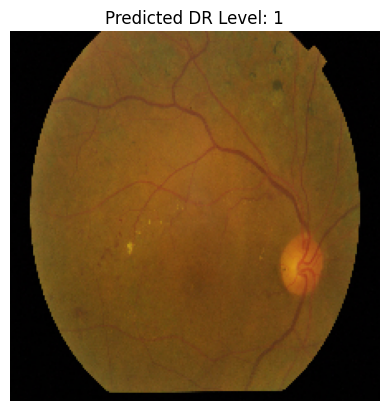

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


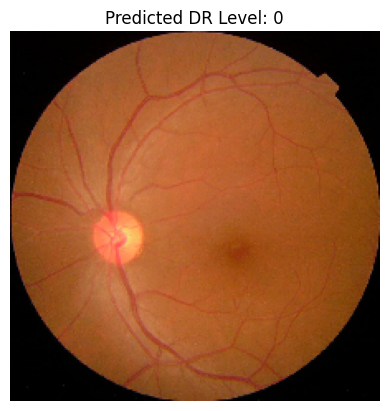

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


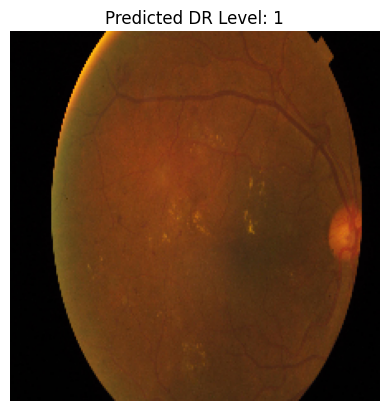

In [51]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def load_and_predict(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    plt.imshow(img)
    plt.title(f"Predicted DR Level: {predicted_class}")
    plt.axis('off')
    plt.show()

# Run prediction
for img_path in sample_images:
    load_and_predict(img_path)